In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import cv2
import torch
from omegaconf import OmegaConf
import hydra
from pprint import pprint
import enum 

sys.path.append('./mediapipe')
import mediapipe as mp
from mediapipe.tasks import python 
from mediapipe.tasks.python import vision
# 
from mediapipe.python.solutions.pose import PoseLandmark
from mediapipe.python.solutions.drawing_utils import DrawingSpec

In [2]:
repo_path = os.path.abspath("./sam2")
if repo_path not in sys.path:
    sys.path.insert(0, repo_path)

print(sys.path)

# Import SAM2 modules
from sam2.sam2_video_predictor import SAM2VideoPredictor
from sam2.build_sam import build_sam2_video_predictor



# source: sam2 repo
def show_mask(mask, ax, obj_id=None, random_color=False): 
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(patches.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

predictor = None 

# video_dir = "./sliced_frames"
# 
# # scan all the JPEG frame names in this directory
# frame_names = [
#     p for p in os.listdir(video_dir)
#     if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
# ]
# frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

def sam2_interface(cartesian_dp, frame_name, video_dir, index):
    global predictor
    
    if hydra.core.global_hydra.GlobalHydra.instance().is_initialized():
        hydra.core.global_hydra.GlobalHydra.instance().clear()


    if not predictor:
        # Initialize the SAM 2 predictor
        sam2_checkpoint = "./sam2/checkpoints/sam2.1_hiera_large.pt"
        # cfg = "./sam2/sam2/configs/sam2.1/sam2.1_hiera_l.yaml"

        config_dir = os.path.abspath("./sam2/sam2/configs")
        config_name = "sam2.1/sam2.1_hiera_l.yaml"

        hydra.initialize_config_dir(config_dir=config_dir, version_base="1.2")

        device = torch.device("cpu")
        predictor = build_sam2_video_predictor(config_name, sam2_checkpoint, device=device)

        predictor = predictor.to(device)

    # take a look the first video frame
    # frame_idx = 0
    print('????')
    # print(frame_names)
    plt.figure(figsize=(9, 6))
    plt.title(f"frame: {frame_name}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_name)))

    inference_state = predictor.init_state(video_path=video_dir)

    # Call this to reset inference state on the video for interactive video segmentation 
    # predictor.reset_state(inference_state)

    # ann_frame_idx = 0  # the frame index we interact with
    # ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)
    
    ann_frame_idx = index  # the frame index we interact with
    ann_obj_id = index + 1  # give a unique id to each object we interact with (it can be any integers)

    # Let's add a positive click at (x, y) = (210, 350) to get started
    points = np.array(cartesian_dp, dtype=np.float32)
    # for labels, `1` means positive click and `0` means negative click
    labels = np.array(np.ones(len(cartesian_dp)), np.int32)
    #labels = np.array([1], np.int32)
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        points=points,
        labels=labels,
    )

    # show the results on the current (interacted) frame
    plt.figure(figsize=(9, 6))
    # plt.title(f"frame {ann_frame_idx}")
    plt.title(f"frame {frame_name}")
    # plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
    plt.imshow(Image.open(os.path.join(video_dir, frame_name)))
    show_points(points, labels, plt.gca())
    show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

['/Users/lajiet/Documents/N_Probability_and_statistics_for_ds/AutomatedHandTracker/sam2', '/Users/lajiet/Documents/N_Probability_and_statistics_for_ds/AutomatedHandTracker/env/lib/python312.zip', '/Users/lajiet/Documents/N_Probability_and_statistics_for_ds/AutomatedHandTracker/env/lib/python3.12', '/Users/lajiet/Documents/N_Probability_and_statistics_for_ds/AutomatedHandTracker/env/lib/python3.12/lib-dynload', '', '/Users/lajiet/Documents/N_Probability_and_statistics_for_ds/AutomatedHandTracker/env/lib/python3.12/site-packages', './mediapipe', '/Users/lajiet/Documents/N_Probability_and_statistics_for_ds/AutomatedHandTracker/env/lib/python3.12/site-packages/setuptools/_vendor']


In [3]:
# Enum found in mediapipe repo: `mediapipe/mediapipe/tasks/python/vision/hand_landmarker.py`
class CopyHandLandmark(enum.IntEnum):
  """The 21 hand landmarks."""

  WRIST = 0
  THUMB_CMC = 1
  THUMB_MCP = 2
  THUMB_IP = 3
  THUMB_TIP = 4
  INDEX_FINGER_MCP = 5
  INDEX_FINGER_PIP = 6
  INDEX_FINGER_DIP = 7
  INDEX_FINGER_TIP = 8
  MIDDLE_FINGER_MCP = 9
  MIDDLE_FINGER_PIP = 10
  MIDDLE_FINGER_DIP = 11
  MIDDLE_FINGER_TIP = 12
  RING_FINGER_MCP = 13
  RING_FINGER_PIP = 14
  RING_FINGER_DIP = 15
  RING_FINGER_TIP = 16
  PINKY_MCP = 17
  PINKY_PIP = 18
  PINKY_DIP = 19
  PINKY_TIP = 20

midknuckle = CopyHandLandmark.MIDDLE_FINGER_MCP

In [4]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

def mediapipe_interface(VIDEO_DIR, file, selected_landmarks):
    holistic_model = mp_holistic.Holistic(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
    )

    #IMAGE_FILES = ["./sliced_frames/00000.jpg"]
    # IMAGE_DIR = "./sliced_frames/"
    BG_COLOR = (192, 192, 192) 
    image = cv2.imread(VIDEO_DIR + '/' + file)
    image_height, image_width, _ = image.shape
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_height, image_width, _ = image.shape
    results = holistic_model.process(image)
    annotated_image = image.copy()

    mp_drawing.draw_landmarks(
      annotated_image, 
      results.right_hand_landmarks, 
      mp_holistic.HAND_CONNECTIONS
    )

    mp_drawing.draw_landmarks(
      annotated_image, 
      results.left_hand_landmarks, 
      mp_holistic.HAND_CONNECTIONS
    )
    
    left_hand_landmarks = []
    right_hand_landmarks = []
    all_hand_landmarks = []  # To store all hand landmark coordinates
    for hand_label, hand_landmarks in zip(["rh", "lh"], [results.right_hand_landmarks, results.left_hand_landmarks]):
        if hand_landmarks:
            for idx, landmark in enumerate(hand_landmarks.landmark):
                if idx in selected_landmarks and selected_landmarks[idx]:
                    # Convert normalized coordinates to pixel coordinates
                    x_pixel = int(landmark.x * image_width)
                    y_pixel = int(landmark.y * image_height)
                    #print(hand_landmarks)
                    #all_hand_landmarks.append([x_pixel, y_pixel])
                    if(hand_label == "rh"):
                        right_hand_landmarks.append([x_pixel, y_pixel])
                    else:
                        left_hand_landmarks.append([x_pixel, y_pixel])
                        
    all_hand_landmarks = left_hand_landmarks + right_hand_landmarks
    if all_hand_landmarks:
        # sam2_interface(cartesian_dp=[[800, 450]])
        sam2_interface(all_hand_landmarks, file, VIDEO_DIR, idx)


    plt.figure(figsize=(9, 6))
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
    plt.title('landmarks')

./sliced_frames/00000.jpg


I0000 00:00:1737833448.310709 8150685 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1737833448.369383 8150832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833448.381063 8150830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833448.383189 8150837 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833448.383229 8150830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833448.384001 8150834 inference_feedback_manager.cc:114] Feedback manager requires a mod

????


frame loading (JPEG): 100%|██████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:05<00:00, 38.84it/s]
/Users/lajiet/Documents/N_Probability_and_statistics_for_ds/AutomatedHandTracker/sam2/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/Users/lajiet/Documents/N_Probability_and_statistics_for_ds/AutomatedHandTracker/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


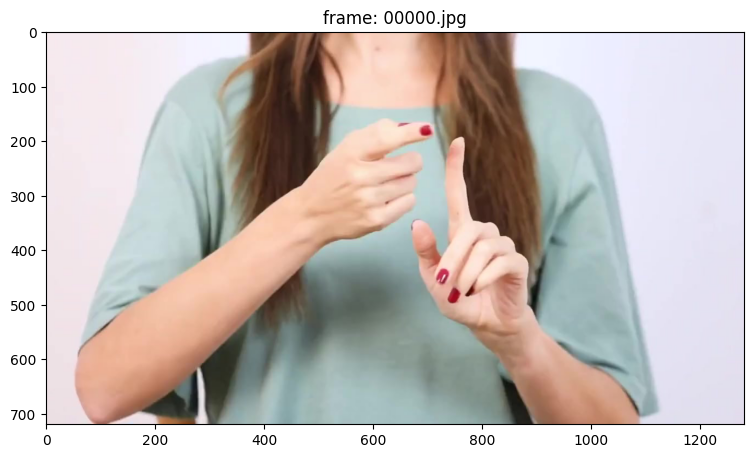

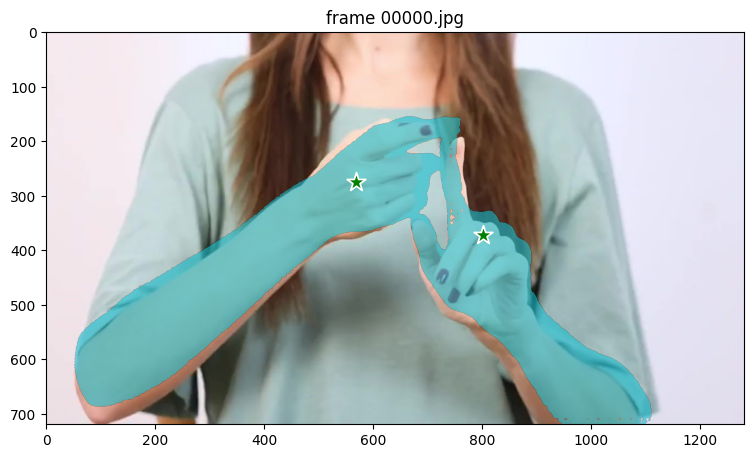

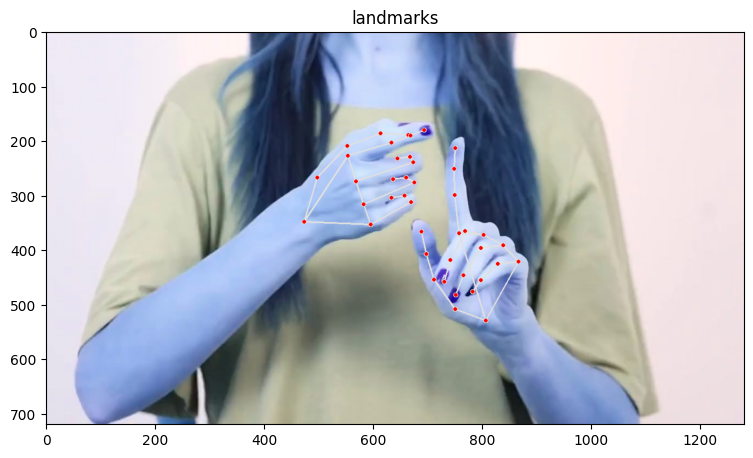

./sliced_frames/00010.jpg
????


I0000 00:00:1737833464.952523 8150685 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1737833465.015321 8151116 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833465.027102 8151116 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833465.029901 8151121 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833465.030044 8151116 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833465.030561 8151118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support 

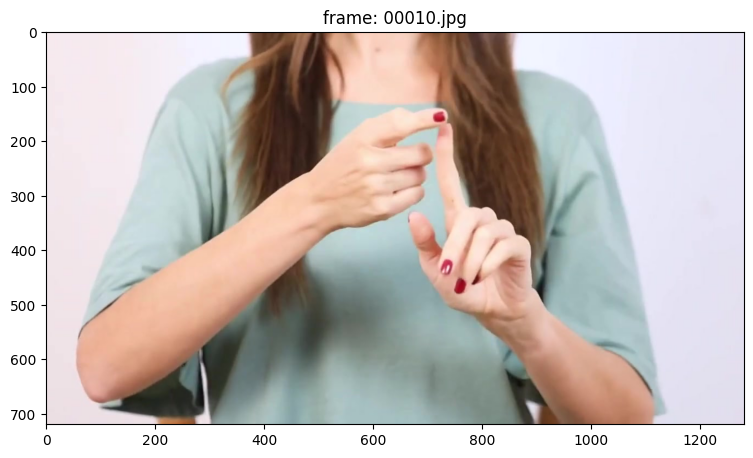

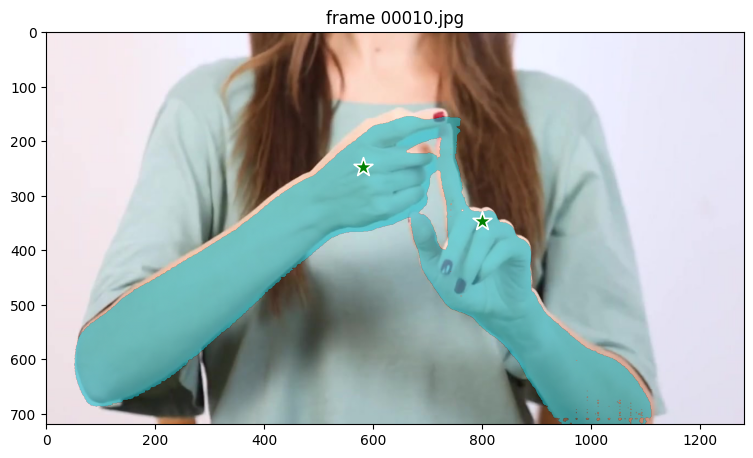

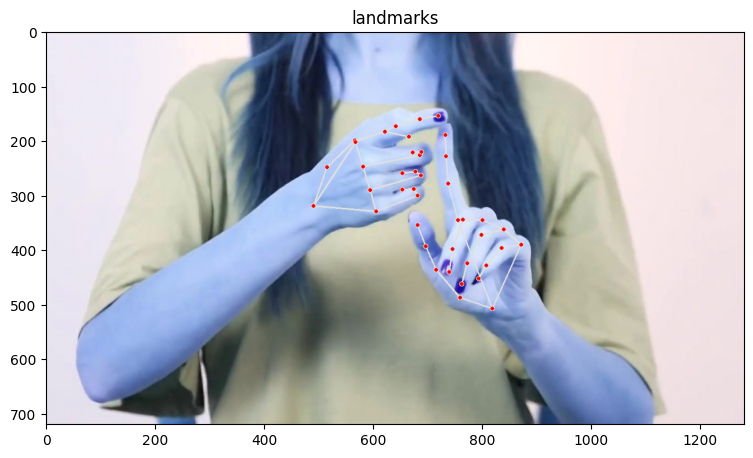

./sliced_frames/00020.jpg
????


I0000 00:00:1737833479.869993 8150685 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1737833479.933804 8151366 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833479.945712 8151366 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833479.948164 8151367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833479.948172 8151364 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833479.948714 8151368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support 

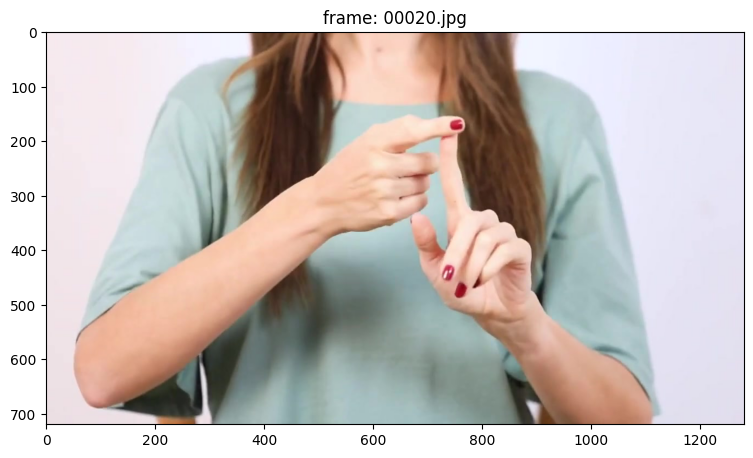

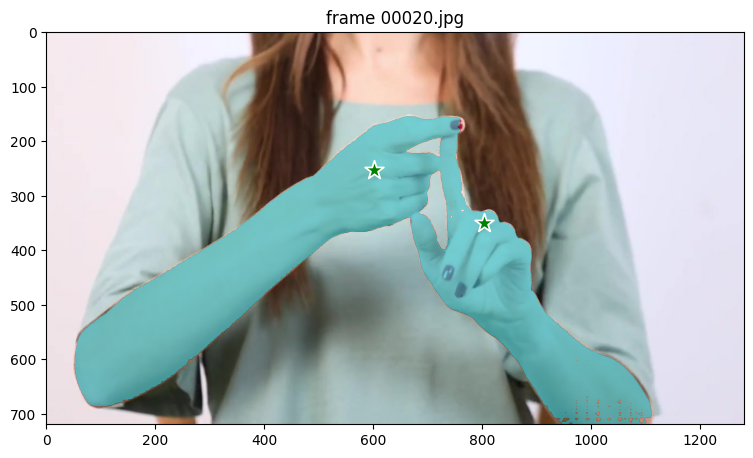

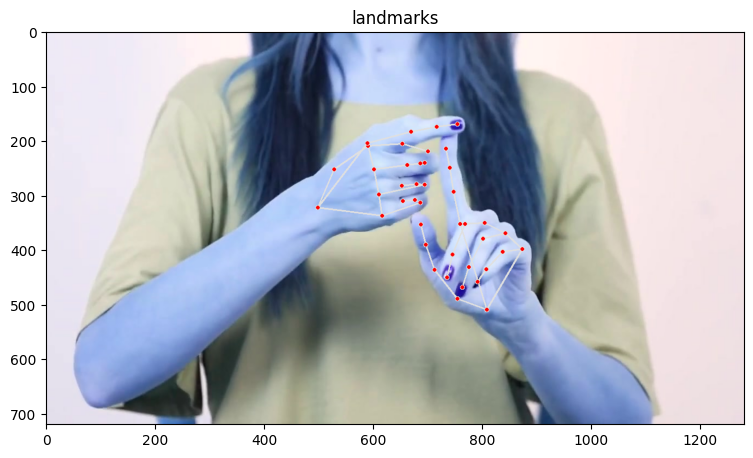

./sliced_frames/00030.jpg
????


I0000 00:00:1737833494.246802 8150685 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1737833494.309704 8151526 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833494.321729 8151526 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833494.324347 8151527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833494.324486 8151526 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833494.324744 8151524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support 

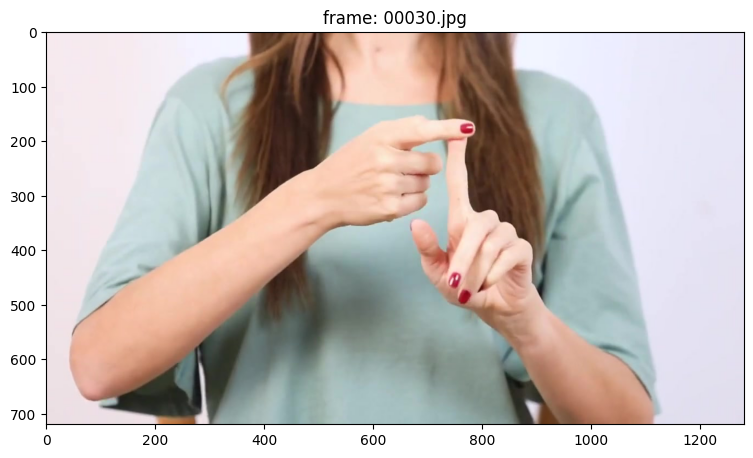

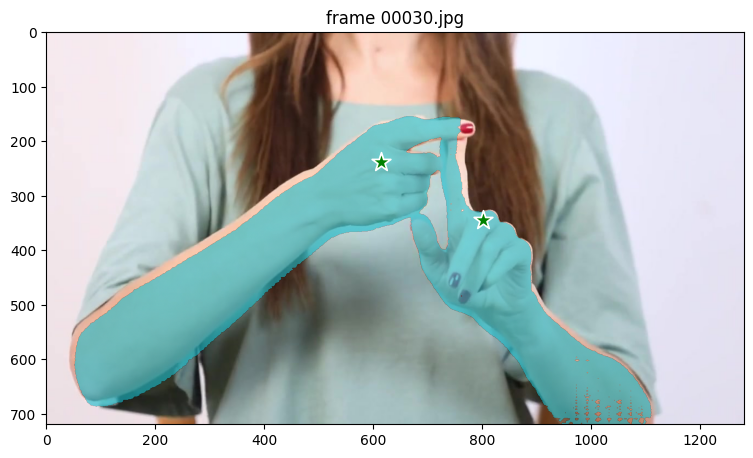

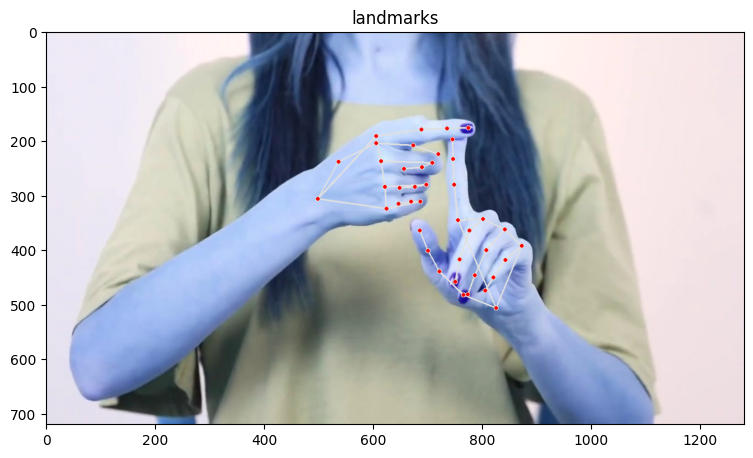

./sliced_frames/00040.jpg
????


I0000 00:00:1737833508.091472 8150685 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1737833508.152319 8151696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833508.164564 8151701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833508.168095 8151701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833508.168364 8151696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833508.169729 8151698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support 

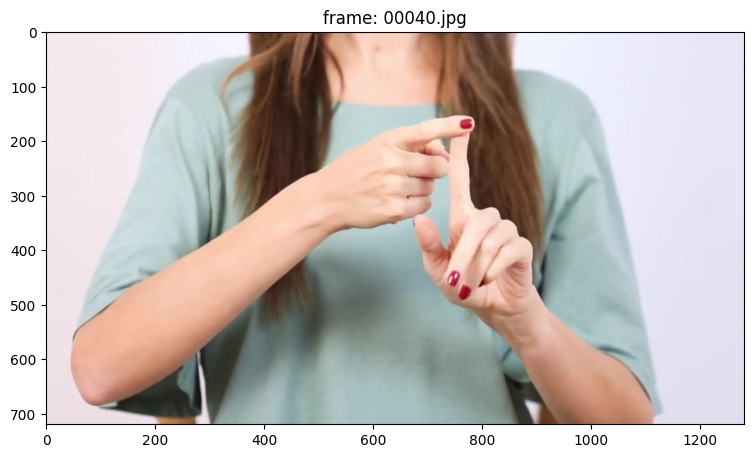

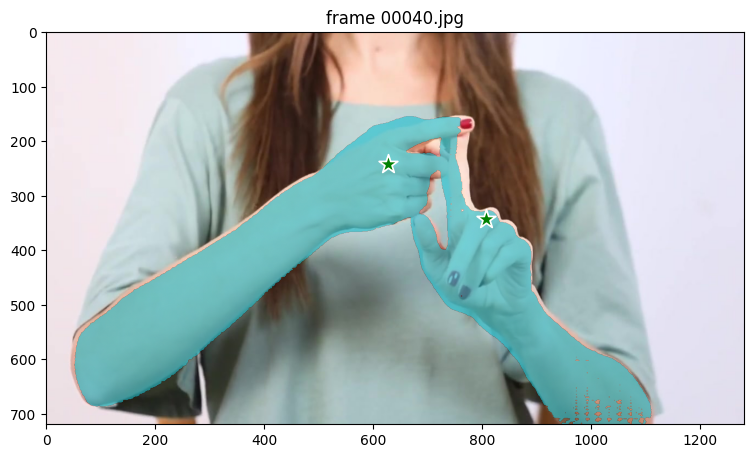

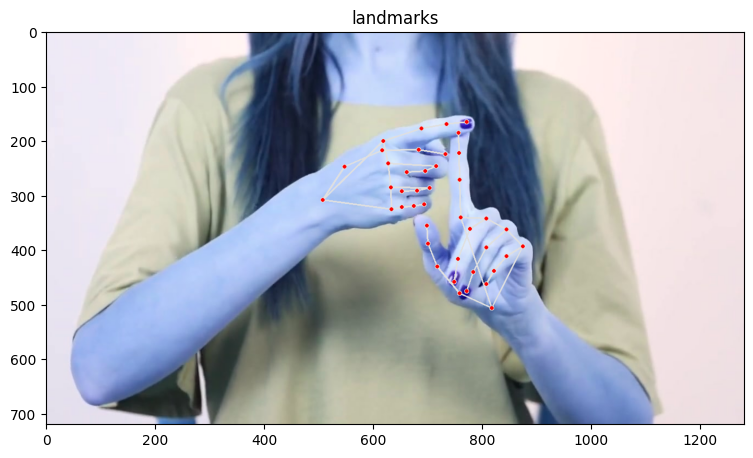

./sliced_frames/00050.jpg
????


I0000 00:00:1737833522.627744 8150685 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1737833522.687148 8151963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833522.697456 8151963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833522.701343 8151964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833522.701474 8151967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833522.701621 8151961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support 

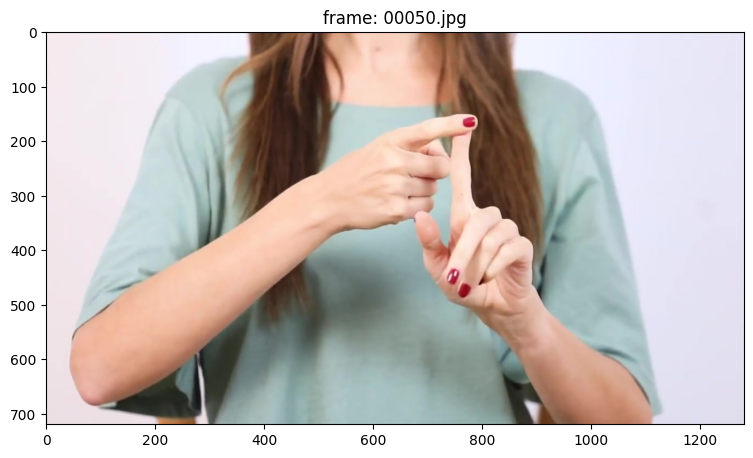

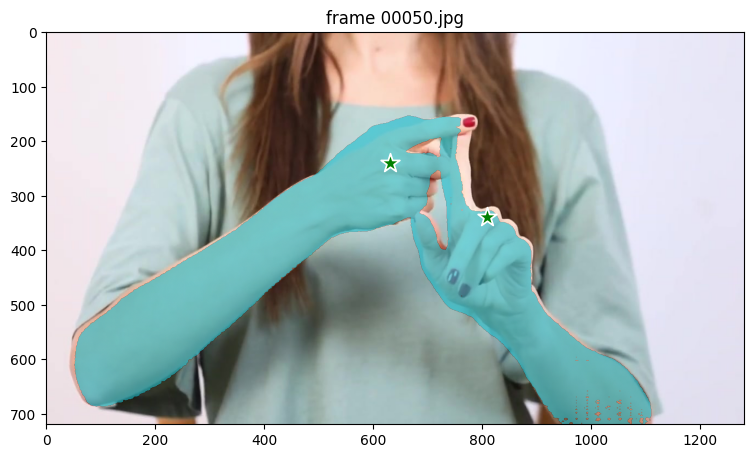

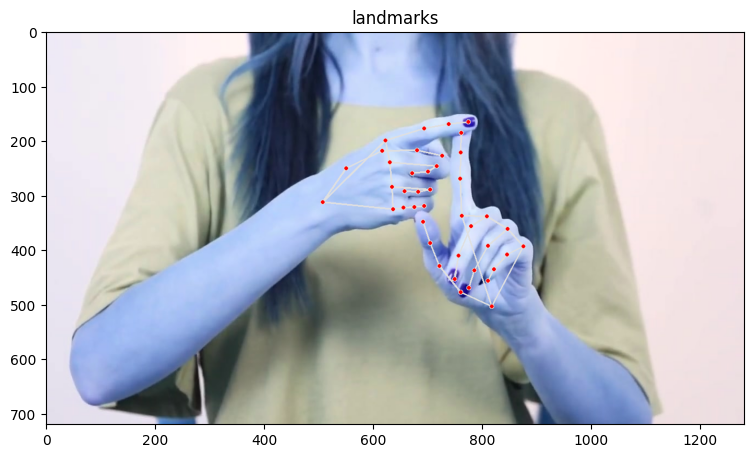

./sliced_frames/00060.jpg
????


I0000 00:00:1737833537.247429 8150685 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1737833537.309498 8152177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833537.321327 8152177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833537.324299 8152176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833537.325583 8152178 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833537.325591 8152174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support 

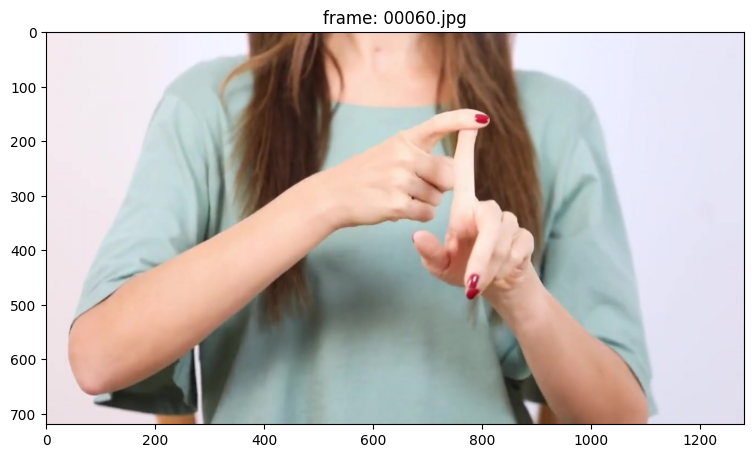

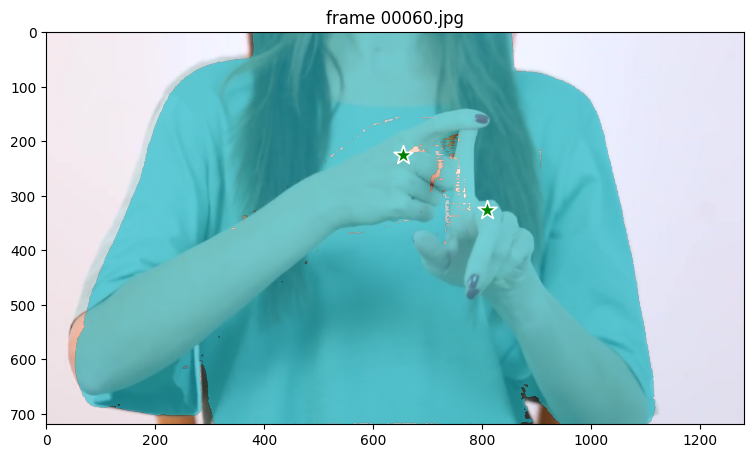

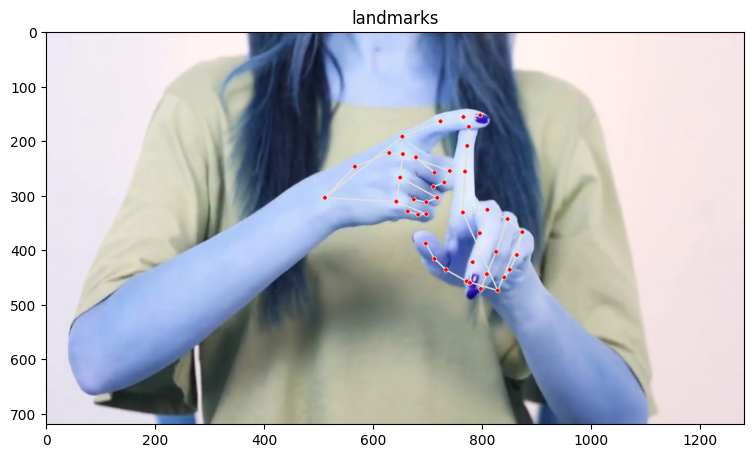

./sliced_frames/00070.jpg
????


I0000 00:00:1737833552.089207 8150685 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1737833552.150587 8152449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833552.161448 8152449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833552.165326 8152452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833552.165329 8152450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833552.166165 8152446 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support 

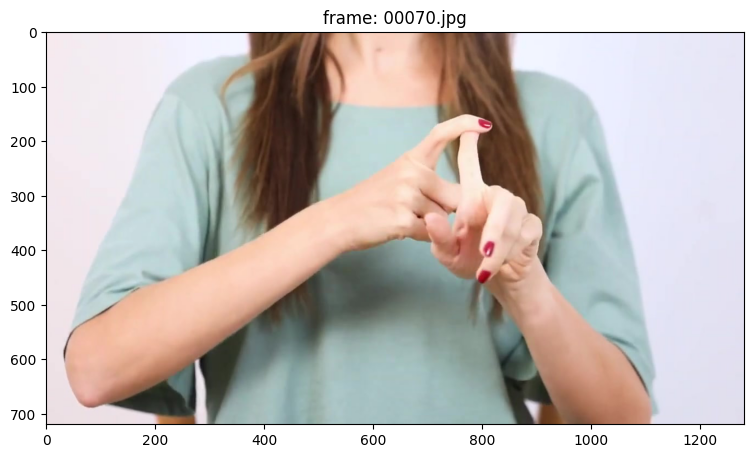

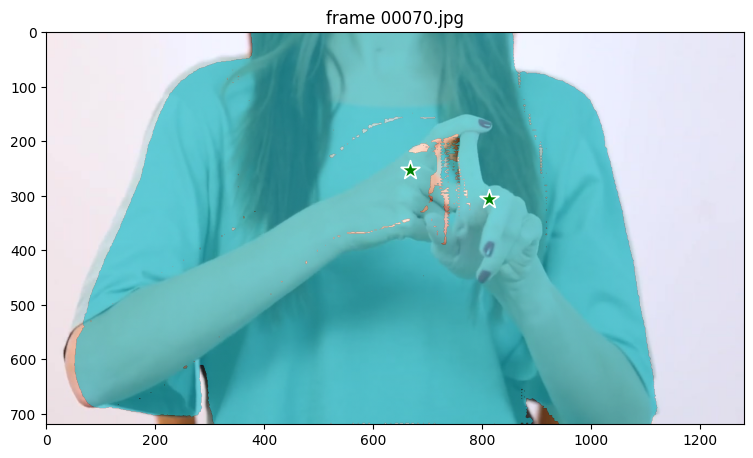

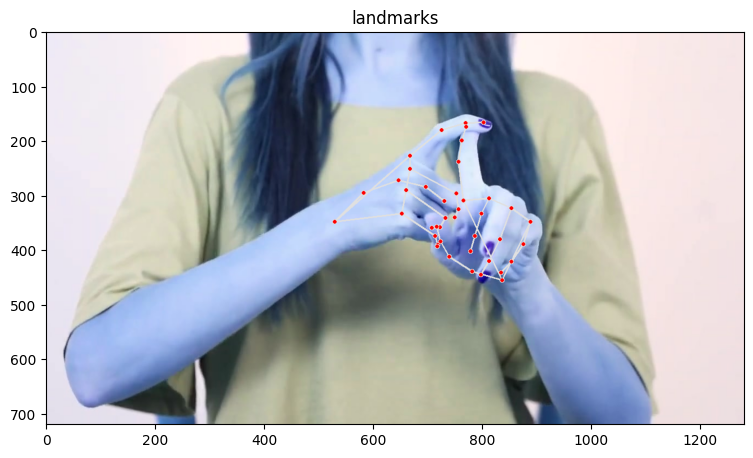

./sliced_frames/00080.jpg
????


I0000 00:00:1737833566.809785 8150685 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1737833566.870041 8152666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833566.880752 8152666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833566.883066 8152666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833566.883283 8152667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833566.883297 8152665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support 

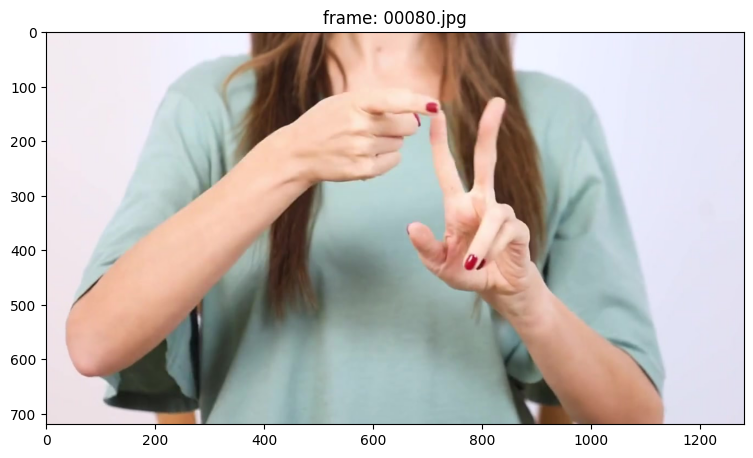

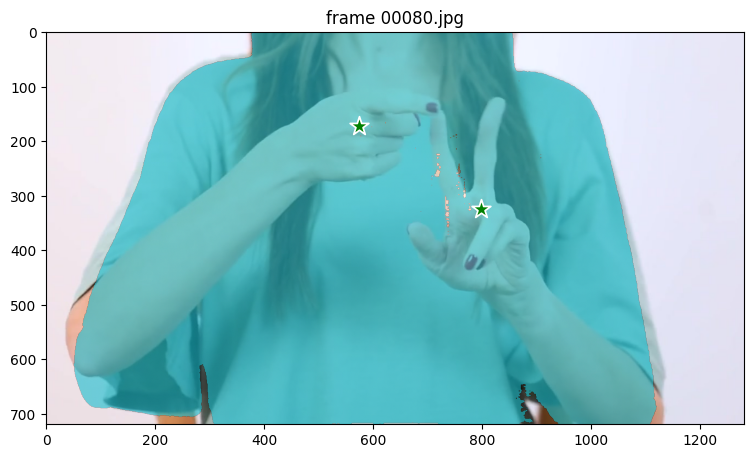

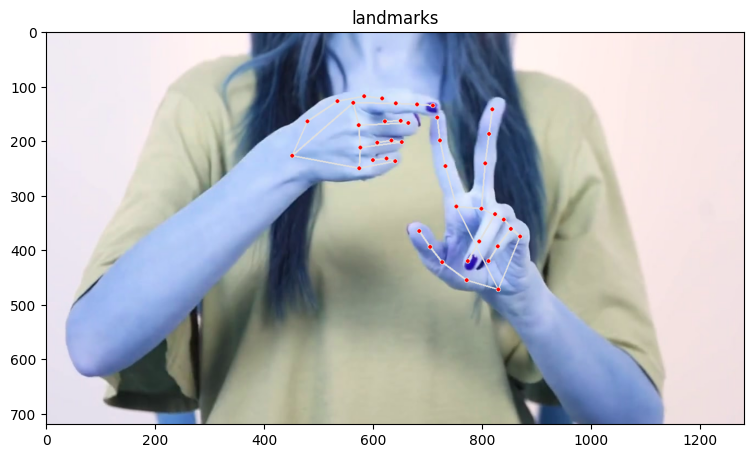

./sliced_frames/00090.jpg
????


I0000 00:00:1737833581.829363 8150685 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1737833581.890151 8153050 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833581.900237 8153050 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833581.902254 8153052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833581.902439 8153053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737833581.904186 8153049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support 

KeyboardInterrupt: 

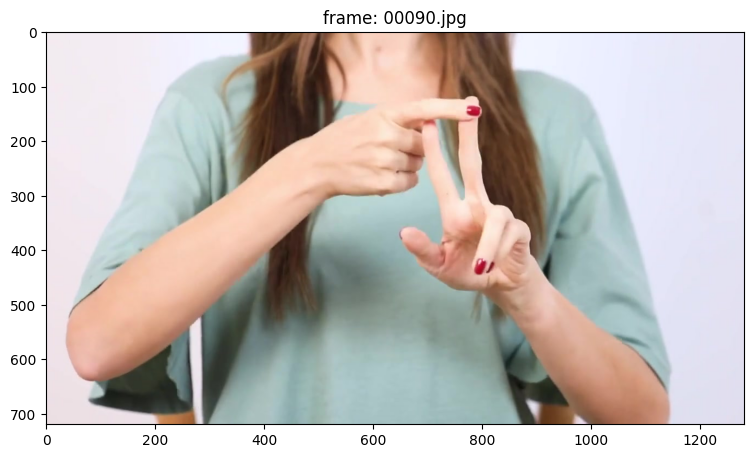

In [5]:
# img = cv2.imread("./sliced_frames/00000.jpg")
# img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.figure(figsize=(9, 6))
# plt.imshow(img_rgb)
# plt.title("Hand")


selected_landmarks = {
    CopyHandLandmark.THUMB_TIP: False,
    CopyHandLandmark.MIDDLE_FINGER_MCP: True,  # middle knuckle
    CopyHandLandmark.MIDDLE_FINGER_TIP: False,  # Exclude this
}

# image = mp.Image.create_from_file("./sliced_frames/00000.jpg")

# holistic_model = mp_holistic.Holistic(
#     min_detection_confidence=0.5,
#     min_tracking_confidence=0.5
# )

#IMAGE_FILES = ["./sliced_frames/00000.jpg"]
# IMAGE_DIR = "./sliced_frames/"
# BG_COLOR = (192, 192, 192) 
# IMAGE_FILES = [
#     os.path.join(IMAGE_DIR, file)
#     for file in os.listdir(IMAGE_DIR)
#     if file.lower().endswith(('.jpeg', '.jpg'))
# ]
# print(sorted(IMAGE_FILES))
VIDEO_DIR= "./sliced_frames"

# scan all the JPEG frame names in this directory
FRAME_NAMES = [
    p for p in os.listdir(VIDEO_DIR)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
FRAME_NAMES.sort(key=lambda p: int(os.path.splitext(p)[0]))
FRAME_NAMES = FRAME_NAMES[::30]

for idx, file in enumerate(sorted(FRAME_NAMES)):
    print(VIDEO_DIR + '/' + file)
    mediapipe_interface(VIDEO_DIR, file, selected_landmarks)
    

    plt.show()